# 02 - CleanLab

Here we go through auditing an image classification dataset with CleanLab.
Multiple packages are available from CleanLab depending on the abstraction level wanting to use.
This showcases the highest abstraction by relying on `DataLab`.

CleanLab (DataLab) works with any ML model trained on your data and uses outputs from this model to detect issues in your data. 

If you have your own image collection to analyze then you need to perform the model training aswell, otherwise we provide pre-computed outputs for the Oxford-PetIIIT dataset.

## Import necessary libraries and download dataset

In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import sys
from pathlib import Path
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from cleanlab import Datalab
from datasets import Dataset, load_dataset
from PIL import Image
from torchvision import datasets, transforms

if IN_COLAB:
    !git clone https://github.com/Digital-Dermatology/data-cleaning-hands-on.git
    sys.path.append("data-cleaning-hands-on")
else:
    sys.path.append("../")

from utils import get_oxford_pets3t

We start by downloading our dataset to analyze.

Either you want to analyze your own collection or you can analyze Oxford PetIIIT.

In [3]:
dataset, df = get_oxford_pets3t(
    root_path="../data", return_dataframe=True, transform=transforms.Resize((256, 256))
)
dataset

Oxford PetIIIT already downloaded to `../data`.


Dataset ImageFolder
    Number of datapoints: 7390
    Root location: ../data
    StandardTransform
Transform: Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=warn)

In [4]:
# 2nd option -> analyze your own data
# dataset = ImageFolder(root_path='path/to/dataset')

# df = pd.DataFrame(dataset.samples)
# df.columns = ["img_path", "label"]
# df["label_name"] = df["label"].apply(lambda x: dataset.classes[x])
# df["img_path"] = df["img_path"].astype(str)

## Load pre-computed features and predicted probabilities

Next we load the pre-computed outputs from our model; refer to [02A_CleanLab_Train_Classifier.ipynb](notebooks/02A_CleanLab_Train_Classifier.ipynb) to see how they were produced or to produce your own for a custom dataset. 

We load two arrays: vector feature embeddings and predicted class probabilities for each image in the dataset.
The predicted class probabilities were obtained from a fine-tuned ResNet-50 model with 5-folds cross-validation, 
and the features were generated using the same model trained on the first 4 folds of the dataset.

Note that Datalab can be run with fewer outputs from your model, you do not need to provide both features and predictions. 
But Datalab can detect more types of issues when provided with more types of outputs from your model. 
The better your model, the more accurately Datalab can detect data issues.

In [5]:
if IN_COLAB:
    pre_computed_path = Path('data-cleaning-hands-on/pre_computed_assets/CleanLab')
else:
    pre_computed_path = Path('../pre_computed_assets/CleanLab')
features = np.load(str(pre_computed_path / "features.npy"))
pred_probs = np.load(str(pre_computed_path / "pred_probs.npy"))

## Use Datalab to find issues in the dataset

We create a Datalab object with the dataset, specifying the name of the column containing the given label for each image.
We then use the `find_issues` method to audit the quality of the dataset, using the provided feature embeddings and predicted class probabilities.

Finally, we generate a report summarizing the issues detected in this dataset.

In [6]:
lab = Datalab(data=df, label_name="label_name")
lab.find_issues(features=features, pred_probs=pred_probs)

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Fitting OOD estimator based on provided features ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 7380 issues found in the dataset.


In [7]:
lab.report(include_description=False)

Here is a summary of the different kinds of issues found in the data:

           issue_type  num_issues
                label        6983
              outlier         260
       near_duplicate         131
underperforming_group           5
              non_iid           1

Dataset Information: num_examples: 7390, num_classes: 37


----------------------- label issues -----------------------

Number of examples with this issue: 6983
Overall dataset quality in terms of this issue: 0.0026

Examples representing most severe instances of this issue:
      is_label_issue   label_score given_label predicted_label
2188            True  1.136803e-14     Siamese         Persian
2012            True  1.236703e-13     Siamese         Persian
2199            True  1.601738e-13     Siamese         Persian
2050            True  8.201404e-13     Siamese         Persian
2142            True  1.378713e-12     Siamese         Persian


---------------------- outlier issues ----------------------

Numbe

## Review the different issue types

Here, we retrieve the examples exhibiting different types of issues found in the dataset (label, outlier, and near_duplicate). This allows us to focus on one type of issue at a time.


We define a function, `make_image_plot` to visualize images, and provide some context to images that might have issues.

In [8]:
def make_image_plot(ax, img, label=None, additional_info=None):
    title = ""
    if label is not None:
        title = "Label {}".format(label)

    if additional_info is not None:
        title += "\n" + additional_info

    if title:
        ax.set_title(title)
    ax.axis("off")
    ax.imshow(img, cmap="gray")

## Near duplicate issues

In this section, we display examples from the dataset that are considered to be nearly duplicated.
The `near_duplicate_issues` DataFrame tells use which examples are considered to have near duplicates, and we can sort them via the `near_duplicate_score` which quantifies how severe this issue is for each image (lower values indicate more severe intances of a type of issue).

This allows us to visualize examples in the dataset that are considered near duplicates, along with their near-duplicate counterparts.

In [9]:
near_duplicate_issues = lab.get_issues("near_duplicate")

near_duplicate_df = near_duplicate_issues.query("is_near_duplicate_issue").sort_values(
    "near_duplicate_score", ascending=True
)

near_duplicate_df

,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
696,True,0.000000,"[602, 612]",0.000000
697,True,0.000000,[717],0.000000
698,True,0.000000,[729],0.000000
699,True,0.000000,[766],0.000000
703,True,0.000000,[792],0.000000
...,...,...,...,...
1089,True,0.061226,[1160],0.004058
660,True,0.108540,[616],0.007379
616,True,0.108540,[660],0.007379
6575,True,0.119920,[6593],0.008204


We define a `plot_near_duplicate_images` function that takes a row from the `near_duplicate_issues` DataFrame as input. This function:

1. Retrieves the original image and its given label based on the row index.

2. Creates a subplot for the original image and each of its near duplicates.

To avoid cluttering the notebook with the same images, we add some logic for tracking previously displayed images and mainly displaying new images.

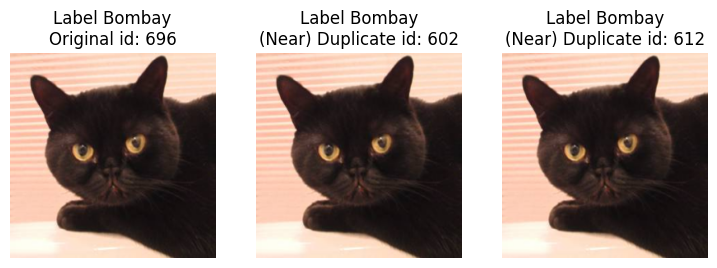

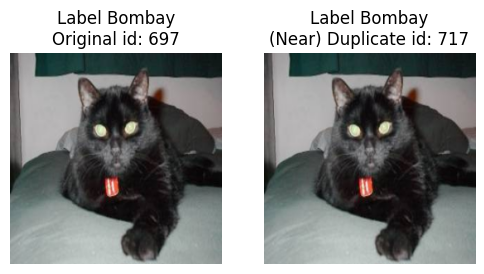

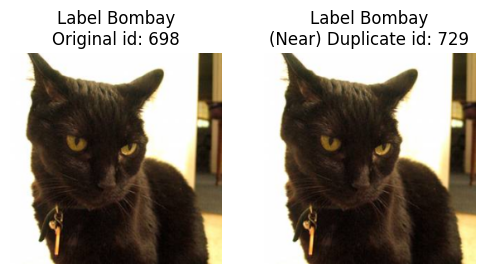

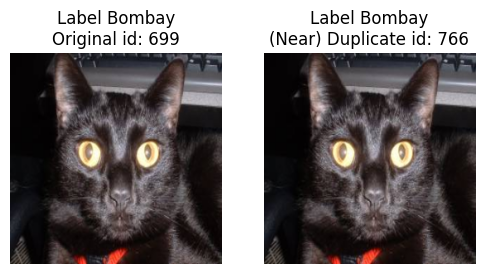

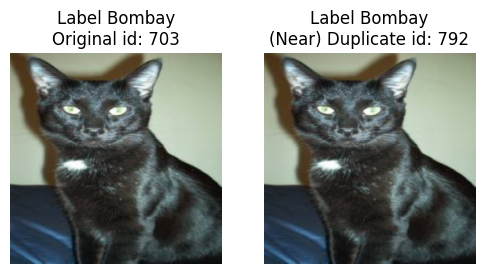

In [10]:
seen_ids = set()


def plot_near_duplicate_images(row):
    label_issues = lab.get_issues("label")

    def get_image_and_given_label(idx):
        image = dataset[idx][0]
        label = label_issues.loc[idx]["given_label"]
        return image, label

    img1_idx = row.name
    if img1_idx in seen_ids:
        return

    duplicate_images = row.near_duplicate_sets
    # how many near duplicates have we seen so far?
    seen_near_duplicates = seen_ids.intersection(duplicate_images)
    # if we have seen all near duplicates, we can skip the rest
    if len(seen_near_duplicates) == len(duplicate_images):
        return

    # If the set has more than 5 near duplicates, at least half of them should be new
    if (
        len(duplicate_images) > 5
        and len(seen_near_duplicates) > len(duplicate_images) / 2
    ):
        return

    num_figures = len(duplicate_images) + 1
    _, ax = plt.subplots(1, num_figures, figsize=(num_figures * 3, 3))
    original_image, label = get_image_and_given_label(img1_idx)
    make_image_plot(
        ax[0], original_image, label, additional_info=f"Original id: {img1_idx}"
    )

    seen_ids.add(img1_idx)

    for i, duplicate_image in enumerate(duplicate_images):
        img2_idx = int(duplicate_image)
        if True:
            img2, label2 = get_image_and_given_label(img2_idx)
            is_near_duplicate = near_duplicate_issues.loc[img2_idx][
                "is_near_duplicate_issue"
            ]
            additional_info = ""
            if is_near_duplicate:
                additional_info = f"(Near) Duplicate id: {img2_idx}"
            make_image_plot(ax[i + 1], img2, label2, additional_info=additional_info)
            seen_ids.add(img2_idx)


near_duplicate_df[:5].apply(plot_near_duplicate_images, axis=1)
plt.show()

## Label issues

In this section, we focus on visualizing examples in the dataset that have label errors.  

We filter the `label_issues` DataFrame to find examples that are considered to have label errors.

Then, we sort the filtered results by their label quality score in ascending order, where examples with the lowest scores are more likely to have label errors.

In [11]:
label_issues = lab.get_issues("label")

labels_df = label_issues.query("is_label_issue").sort_values(
    "label_score", ascending=True
)
labels_df.head(5)

,is_label_issue,label_score,given_label,predicted_label
2188,True,1.136803e-14,Siamese,Persian
2012,True,1.236703e-13,Siamese,Persian
2199,True,1.601738e-13,Siamese,Persian
2050,True,8.201404e-13,Siamese,Persian
2142,True,1.378713e-12,Siamese,Persian


We define a `plot_label_issues` function to visualize the examples with label errors. This function:

1. Retrieves the image, given label, and predicted label based on the row index.

    - Additionally, we fetch the file name of the image to use as the title of the plot when necessary.

2.  Creates a plot for the image using the `make_image_plot` function with the given label and additional information about the predicted label.

Finally, we apply the `plot_label_issues` function to each row of the filtered and sorted results.

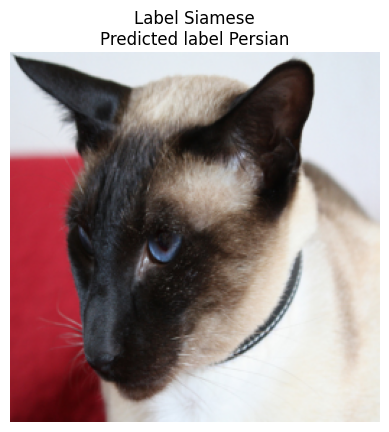

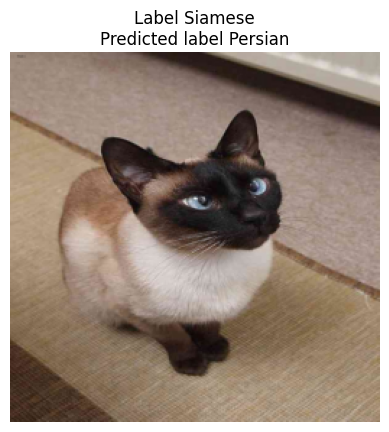

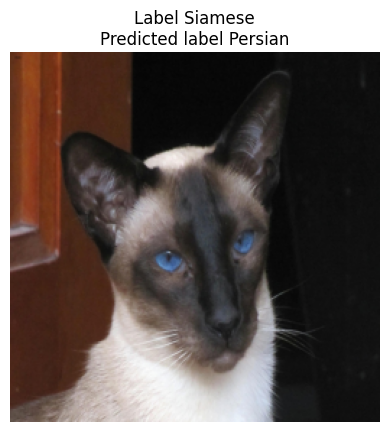

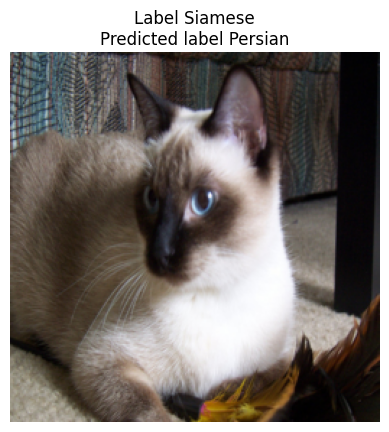

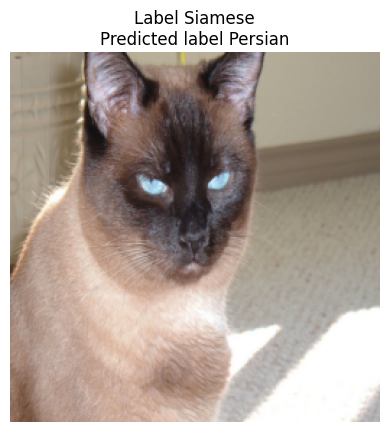

In [12]:
def plot_label_issues(row):
    idx = row.name
    image = dataset[idx][0]
    image_filename = df.iloc[idx]["img_path"].split("/")[-1]
    label = label_issues.loc[idx]["given_label"]
    predicted_label = label_issues.loc[idx]["predicted_label"]

    filename_label = image_filename.split("_")[0]
    ax = plt.subplot(1, 1, 1)
    additional_info = f"Predicted label {predicted_label}"
    if label.split(".")[0] != filename_label:
        additional_info += f"\nFilename: {image_filename}"

    make_image_plot(ax, image, label, additional_info=additional_info)
    plt.show()


labels_df[:5].apply(plot_label_issues, axis=1)
plt.show()

## Outlier issues

In this section, we focus on reviewing atypical examples in the dataset. These are examples that are significantly different from the majority of the dataset, which may have an outsized impact on models fit to this data.

Similarly to the previous section, we filter the `outlier_issues` DataFrame to find examples that are considered to be outliers. We then sort the filtered results by their outlier quality score in ascending order, where examples with the lowest scores appear least typical based on the rest of the dataset.

In [13]:
outlier_issues = lab.get_issues("outlier")

outliers_df = outlier_issues.query("is_outlier_issue").sort_values(
    "outlier_score", ascending=True
)
outliers_df.head(5)

,is_outlier_issue,outlier_score
265,True,0.002250
2907,True,0.004291
1505,True,0.005636
4638,True,0.015617
4143,True,0.015815


To visualize the most anomalous examples, we:

We define a `plot_outlier_issues` function to visualize the examples that are most anomalous. This function:
that takes a row from the `outlier_issues` DataFrame as input. This function:

1. Retrieves the image, given label and sampled images from the same class, used for comparison.

2. Creates a subplot for the original image and the sampled images.

3. Uses the `make_image_plot` function to display the images with additional information about their labels.

The `plot_outlier_issues` function is applied to each row of the filtered and sorted results.

By visualizing these anomalous examples with some additional context, we can gain insights into the dataset's diversity and the potential challenges that these unusual examples may pose during model training and evaluation.

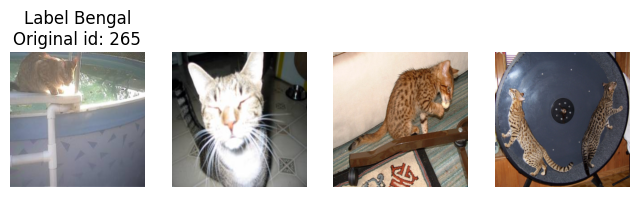

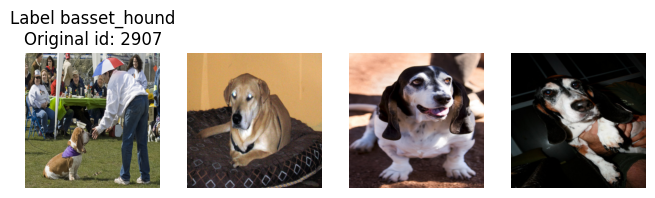

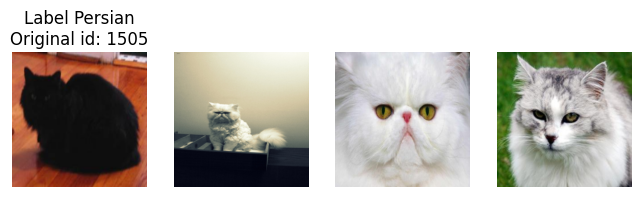

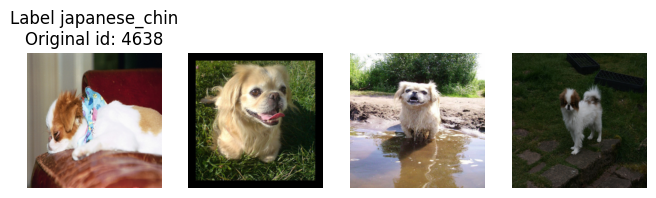

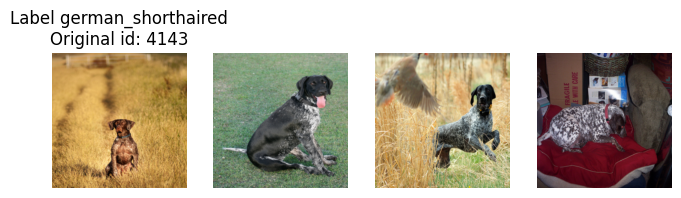

In [14]:
def plot_outlier_issues(row):
    label_issues = lab.get_issues("label")
    N_comparison_images = 3

    def sample_from_class(label, number_of_samples, index):
        index = int(index)

        non_outlier_indices = (
            label_issues.join(outlier_issues)
            .query("given_label == @label and not is_outlier_issue")
            .index
        )
        non_outlier_indices_excluding_current = non_outlier_indices[
            non_outlier_indices != index
        ]

        sampled_indices = np.random.choice(
            non_outlier_indices_excluding_current, number_of_samples, replace=False
        )

        label_scores_of_sampled = label_issues.loc[sampled_indices]["label_score"]

        top_score_indices = np.argsort(label_scores_of_sampled.values)[::-1][
            :N_comparison_images
        ]

        top_label_indices = sampled_indices[top_score_indices]

        sampled_images = [dataset[int(i)][0] for i in top_label_indices]

        return sampled_images

    def get_image_given_label_and_samples(idx):
        image_from_dataset = dataset[idx][0]
        corresponding_label = label_issues.loc[idx]["given_label"]
        comparison_images = sample_from_class(corresponding_label, 30, idx)[
            :N_comparison_images
        ]

        return image_from_dataset, corresponding_label, comparison_images

    idx = row.name
    image, label, comparison_images = get_image_given_label_and_samples(idx)
    _, ax = plt.subplots(1, N_comparison_images + 1, figsize=(8, 5))

    make_image_plot(ax[0], image, label, additional_info=f"Original id: {idx}")
    for i, comparison_image in enumerate(comparison_images):
        make_image_plot(ax[i + 1], comparison_image)
    plt.show()


outliers_df[:5].apply(plot_outlier_issues, axis=1)
plt.show()